### Dataset Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions:

    <>train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    <>PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is  their number within the group. People in a group are often family members, but not always.
    <>HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    <>CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    <>Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    <>Destination - The planet the passenger will be debarking to.
    <>Age - The age of the passenger.
    <>VIP - Whether the passenger has paid for special VIP service during the voyage.
    <>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    <>Name - The first and last names of the passenger.
    <>Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
    
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [3]:

# Import Libraries

# Data wrangling
import pandas as pd
import numpy as np
from collections import Counter


# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# File
import os


# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [134]:
# Import Files
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [135]:
# Sample Data
train.sample(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2218,2377_01,Europa,True,C/83/P,PSO J318.5-22,32.0,False,0.0,0.0,0.0,0.0,0.0,Alark Noxiong,True
3307,3552_02,Europa,True,B/136/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Canonon Castery,True
3982,4252_01,Earth,False,F/795/S,TRAPPIST-1e,15.0,False,156.0,1.0,1132.0,192.0,33.0,Annon Knoxtones,True


In [136]:
# Sample Data
test.sample(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2430,5317_02,Earth,True,G/866/S,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,Dord Gibbsonton
1074,2265_01,Earth,False,F/443/S,TRAPPIST-1e,34.0,False,0.0,NaN,0.0,529.0,0.0,Ellard Brownings
46,0109_01,Earth,False,F/22/P,TRAPPIST-1e,34.0,False,0.0,0.0,39.0,1.0,556.0,Tonald Wolferton


In [137]:
# Inspect Data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [138]:
# Inspect Data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [139]:
#Print shape of Dataset
print(f'The shape of train data is: \n', train.shape)
print(f'The shape of test data is: \n', test.shape)

The shape of train data is: 
 (8693, 14)
The shape of test data is: 
 (4277, 13)


In [140]:
# Function to extract cabin grp and side 
def cabin_split(x):
    ## try and exception is used to navigate through the nan values
    try:
        u= x.split('/')
        return str(u[0] + u[2])
    except AttributeError as e:
        return x

# Extract cabin grp and side
for data in [test, train]:
    data["Cabin_grp"] = data.Cabin.apply(cabin_split)


In [141]:
# Function fill the Cabin_grp
for data in [train, test]:
    data.Cabin_grp.fillna(method="pad", inplace=True)

# Function to Fill the Cabin from the Carbin_grp    
def fill_cabin(data):
    ## try and exception is used to navigate through the nan values
    try:
        a = data.str.split('')
        return str(a[1] + "/" + str(np.random.choice(a=1500, size=1)[0])+ "/" + a[2])
    except AttributeError as e:
        return data

# Fill the Cabin from the Carbin_grp
for data in [test, train]:
    for index, value in enumerate(list(data.Cabin.isna())):
        if value:
            data["Cabin"].iloc[index]= data.Cabin_grp.apply(fill_cabin).iloc[index]


In [142]:
# Check for NaN values
train.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Cabin             0
Transported       0
Cabin_grp         0
dtype: int64

In [143]:
# Check for NaN values
test.isnull().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
Cabin             0
Cabin_grp         0
dtype: int64

In [144]:
# Sample Data
train.sample(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_grp
3860,4137_01,Earth,False,F/778/S,55 Cancri e,39.0,False,664.0,0.0,0.0,40.0,0.0,Lonna Rocknight,False,FS
1663,1764_02,Mars,False,E/134/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Cin Laai,False,ES


In [145]:
# Sample Data
test.sample(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_grp
2054,4434_01,Mars,False,F/837/S,TRAPPIST-1e,26.0,False,566.0,6.0,579.0,1508.0,0.0,Cord Sha,FS
3971,8655_01,Earth,False,F/1672/S,PSO J318.5-22,20.0,False,0.0,0.0,20.0,529.0,1.0,Alfrey Tranklinay,FS


### EXPLOROTARY DATA ANALYSIS


#### Categorical Variables : HomePlanet, CryoSleep, Destination,VIP


##### 1. HomePlanet

In [146]:
train.HomePlanet.value_counts(dropna=False)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64

In [147]:
#Mean "Transported" by HomePlanet

train[['HomePlanet', 'Transported']].groupby('HomePlanet', as_index=False).mean().sort_values(by= 'Transported', ascending=False)

# Europa, Mars, Earth

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


Text(0.5, 1.0, 'Transported Probability by Home Planet')

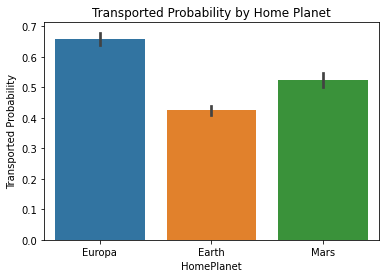

In [148]:
# Plot
sns.barplot(x = 'HomePlanet', y ='Transported', data = train)
plt.ylabel('Transported Probability')
plt.title('Transported Probability by Home Planet')


##### 2. Destination

In [149]:
train['Destination'].value_counts(dropna=False)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64

In [150]:
# Mean "Transported" by Destination
train[["Destination", "Transported"]].groupby('Destination', as_index=False).mean().sort_values(by="Transported", ascending=False)

# 55 Cancri e, PSO J318.5-22, TRAPPIST-1e

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.471175


Text(0.5, 1.0, 'Transported Probability by Destination')

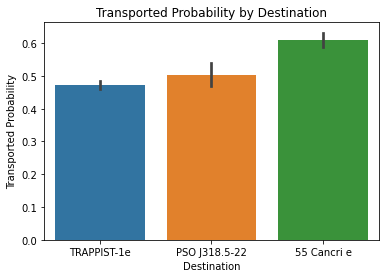

In [151]:
# Plot
sns.barplot(x="Destination", y="Transported", data=train)
plt.ylabel('Transported Probability')
plt.title('Transported Probability by Destination')

##### 3. CryoSleep

In [152]:
train.CryoSleep.value_counts(dropna=False)

False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64

In [153]:
# Mean "Transpored" by CryoSleep 

train[['CryoSleep', 'Transported']].groupby("CryoSleep", as_index=False).mean().sort_values(by="Transported", ascending=False)

# True, False

,CryoSleep,Transported
1,True,0.817583
0,False,0.328921


Text(0, 0.5, 'Transported Probability by CryoSleep')

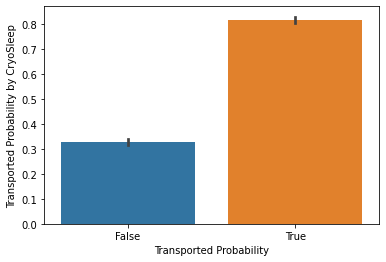

In [154]:
# Plot
sns.barplot(x="CryoSleep", y="Transported", data=train)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by CryoSleep")

##### 4. VIP

In [155]:
train.VIP.value_counts(dropna=False)

False    8291
NaN       203
True      199
Name: VIP, dtype: int64

In [156]:
# Mean "Transported" by VIP 

train[['VIP', 'Transported']].groupby("VIP", as_index=False).mean().sort_values(by="Transported", ascending=False)

# False, True

,VIP,Transported
0,False,0.506332
1,True,0.381910


Text(0, 0.5, 'Transported Probability by VIP')

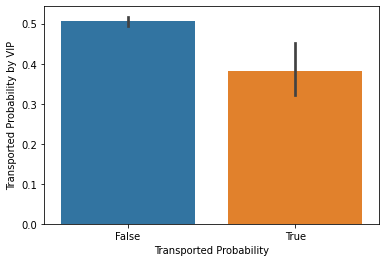

In [157]:
# Plot
sns.barplot(x="VIP", y="Transported", data=train)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by VIP")

### FILL MISSING TEST VALUES

##### From the EDA performed earlier by Rasheed, he defined the functions below for filling missing values

In [158]:
# For Functions for Missing Values
def fill_missing_1(data, target_column: str, cond_column1: str, cond_column2: str, cond_value1: str, cond_value2, fill):
    common= data[target_column].isna()
    condition= [(data[cond_column1]>= cond_value1) & (data[cond_column2]== cond_value2) & (common)]
    fill_with= [fill]
    data[target_column]= np.select(condition, fill_with, default= data[target_column].values)

def fill_missing_2(data, target_column: str, cond_column: str, cond_value:int, fill):
    common= data[target_column].isna()
    cond= [(data[cond_column] <= cond_value) &(common)]
    fill_with= [fill]
    data[target_column]= np.select(cond, fill_with, default= data[target_column].values)

def fill_missing_3(data, target_column: str, cond_column1: str, cond_column2: str, cond_value1: str, cond_value2, fill):
    common= data[target_column].isna()
    condition= [(data[cond_column1]== cond_value1) & (data[cond_column2]== cond_value2) & (common)]
    fill_with= [fill]
    data[target_column]= np.select(condition, fill_with, default= data[target_column].values)

def fill_missing_4(data, target_column: str, cond_column1: str,  cond_value1: str, fill):
    common= data[target_column].isna()
    condition= [(data[cond_column1]== cond_value1)  & (common)]
    fill_with= [fill]
    data[target_column]= np.select(condition, fill_with, default= data[target_column].values)

In [159]:
# Check if both train and test datas as same number of unique carbon_grp values

len(train.Cabin_grp.unique()) == len(test.Cabin_grp.unique())

True

In [160]:
# Fill: For ages greater than 40 and cabin_grp AP,BP, BS, CS , CP HomePlanet is Europa
# Fill: For ages greater than 40  and cabin_grp GS, GP homeplanet is Earth
for grp in ["AP","BP", "BS", "CS" , "CP", "GS", "GP"]:
    if grp in ["GS", "GP"]:
        fill_missing_1(train, 'HomePlanet', "Age", 'Cabin_grp', 40, grp, 'Earth')
        fill_missing_1(test, 'HomePlanet', "Age", 'Cabin_grp', 40, grp, 'Earth')
    else:
        fill_missing_1(train, 'HomePlanet', "Age", 'Cabin_grp', 40, grp, 'Europa')
        fill_missing_1(test, 'HomePlanet', "Age", 'Cabin_grp', 40, grp, 'Europa')


In [161]:
# Fill for Shopmall and VIP sujected to Age 12 and 20 respectively
for data in [train, test]:
    fill_missing_2(data, 'ShoppingMall', 'Age', 12, 0)
    fill_missing_2(data, 'VIP', 'Age', 20, False)

In [162]:
# Fill Missing Values (Contd)
for data in [train, test]:
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'ES', 'TRAPPIST-1e', 'Mars')
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'ES', 'PSO J318.5-22', 'Earth')
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'ES', '55 Cancri e', 'Europa')
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'ES', '55 Cancri e', 'Europa')
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'DS', '55 Cancri e', 'Europa')
    fill_missing_3(data, 'HomePlanet', 'Cabin_grp', 'Destination', 'DP', '55 Cancri e', 'Europa')


    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'AS', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'AP', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'BS', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'BP', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'CS', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'CP', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'TP', 'Europa')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'FS', 'Earth')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'GS', 'Earth')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'GP', 'Earth')
    fill_missing_4(data, 'HomePlanet', 'Cabin_grp', 'EP', 'Earth')

In [163]:
# Fill Missing Values (Contd)
for data in [train, test]:
    data['HomePlanet']= data['HomePlanet'].fillna('Mars')

    fill_missing_4(data, 'CryoSleep', 'Cabin_grp', 'BS', True)
    fill_missing_3(data, 'CryoSleep', 'Cabin_grp', 'Destination', 'GP', '55 Cancri e', True )
    fill_missing_3(data, 'CryoSleep', 'Cabin_grp', 'Destination', 'GS', '55 Cancri e', True )
    ## fill the remaining missing values with False
    data['CryoSleep'] = data['CryoSleep'].fillna(False)

    ## fill VIP the misiing values with False
    data['VIP']= data['VIP'].fillna(False)

    ## fill Destination with TRAPPIST-1e
    data['Destination']= data['Destination'].fillna('TRAPPIST-1e')



In [164]:
## Group by HomePlanet,  cabin_grp and destination then fill with median

for data in [train, test]:
    for col in ['Spa', 'VRDeck', 'ShoppingMall', 'RoomService', 'Age', 'FoodCourt']:
        data[col] = data.groupby(['HomePlanet','Cabin_grp', 'Destination'])[col].apply(lambda x: x.fillna(x.median()))

# Fill the remaining Nan Values:

for data in [train, test]:
    for col in ['Spa', 'VRDeck', 'ShoppingMall', 'RoomService', 'Age', 'FoodCourt']:
        median = data[col].median()
        data[col].fillna(value=median, inplace=True)

In [165]:
# Check for NaN values
train.isnull().sum().sort_values(ascending=False)

Name            200
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Cabin_grp         0
dtype: int64

In [166]:
# Check for NaN values
test.isnull().sum().sort_values(ascending=False)

Name            94
PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Cabin_grp        0
dtype: int64

In [167]:
# Sample Data
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_grp
6102,6444_02,Earth,True,G/1041/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Elicey Domington,True,GP
6781,7160_01,Earth,True,G/1152/P,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Pennie Headardyer,True,GP
3614,3883_03,Europa,True,B/150/S,55 Cancri e,13.0,False,0.0,0.0,0.0,0.0,0.0,Dira Unreezy,True,BS
3035,3283_03,Earth,False,G/521/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,646.0,138.0,Byront Strongers,False,GS
5670,6024_01,Earth,True,G/975/P,PSO J318.5-22,16.0,False,0.0,0.0,0.0,0.0,0.0,Carlie Fowlaney,True,GP


In [168]:
# Sample Data
test.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_grp
1296,2779_01,Earth,False,F/577/P,TRAPPIST-1e,60.0,False,454.0,1.0,91.0,1.0,227.0,Becca Monroellynn,FP
2951,6499_01,Earth,False,G/1052/P,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,NaN,GP
398,0838_02,Mars,False,D/35/P,TRAPPIST-1e,23.0,False,2577.0,0.0,0.0,0.0,2.0,Chal Concy,DP
3916,8538_01,Mars,False,F/1644/S,TRAPPIST-1e,28.0,False,2585.0,0.0,4.0,2.0,7.0,Hoow Bla,FS
2441,5329_05,Earth,False,GP,PSO J318.5-22,45.0,False,0.0,311.0,115.0,4.0,328.0,Delley Mclardson,GP


In [169]:
# Print out shape of datasets
print(f'The shape of train data is: \n', train.shape)
print(f'The shape of test data is: \n', test.shape)

The shape of train data is: 
 (8693, 15)
The shape of test data is: 
 (4277, 14)


#### Save to csv

In [170]:
# from pandas import DataFrame

# # Function to make directory and create file
# def create_csv(filename:str, data:DataFrame):
#     directory = "Wrangled_Data/"
#     path = os.path.join(directory, filename)

#     # Make directory if directory doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Check if file exists and delete
#     if os.path.exists(path):
#         os.remove(path)

#     # Read Dataframe to csv    
#     data.to_csv(path, index=False)


# create_csv("train_new.csv", train)
# create_csv("test_new.csv", test)

# FEATURE ENIGNEERING

**Any combinations of the following functions can be used at the discretion of the person/persons building the model.**

In [171]:
def AgeGrade(data):
  '''
  Takes a dataframe
  Bins the ages into 5 different age grades in increasing order. (A-E)
  Drops the Age column
  This may help reduce noise in the dataset.
  

  Returns a Dataframe with an AgeGrade Feature column. Containing all the age Grades.
  '''

  data['AgeGrade'] = pd.cut(data.Age, bins = 5, labels = ['A','B', 'C', 'D', 'E'])
  data = data.drop('Age', axis = 1)
  return data

In [172]:
def Luxury(data):
  '''
  Takes a dataframe
  creates a Luxury column based on the total amount spent on Titanics Luxury ammenties (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)
  Drops all other titanic Luxury Ammenties.
  This may help reduce noise in the dataset.



  Returns a dataframe with a Luxury Column.
  '''
  data['Luxury'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
  data = data.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'], axis = 1)
  return data

In [179]:
def DeckSide(data):
  '''  
  Takes a dataframe
  Splits the Cabin_grp into a Deck and Side column
  This will help reduce the number of features after One hot encoding.
  This may also help reduce noise.



  Returns a dataframe with Cabin_grp split into Deck and Side feature columns. 

  '''
  data['Deck'] = data.Cabin_grp.str[0]
  data['Side'] =data.Cabin_grp.str[1]
  data = data.drop('Cabin_grp', axis = 1)
  return data

In [174]:
def Alone(data):
  '''
  Takes a dataframe
  Creates a column from passenger Id  (based on whether the passenger was alone in the group)
  Makes sense since people in the same group are often family members



  Returns a dataframe with a feature column 'Alone'

  '''

  group_num = list(data.PassengerId.str.split('_',expand = True)[0])
  unique_num= []
  for num in group_num:
    if group_num.count(num) > 1:
      unique_num.append('False')
    else: 
      unique_num.append('True')
  unique_num = np.array(unique_num)
  data['Alone'] = unique_num
  return data

In [175]:
def GroupSize(data):
  '''
  Similar to the Alone function.
  But instead, groups passengers according to the number of persons in their group and not whether they are alone or not.

  Takes a dataframe.
  Creates a column of GroupSize (1,2,3, Above 3) from the PassengerId
  This may help reduce noise in the data set


  Returns A dataframe with a GroupSize feature column.
  '''
  group_num = list(data.PassengerId.str.split('_',expand = True)[0])
  unique_num= []
  for num in group_num:
    if group_num.count(num) == 1:
      unique_num.append('1')
    elif group_num.count(num) == 2:
      unique_num.append('2')
    elif group_num.count(num) == 3:
      unique_num.append('3')
    else: 
      unique_num.append('Above 3')
  unique_num = np.array(unique_num)
  data['GroupSize'] = unique_num
  return data

In [205]:
def get_dummies(data):
  '''
  Takes in a DataFrame
  Drops Irrelevant columns
  Transforms categorical features into dummy encodings.


  Returns the transformed data
  '''
  data = data.drop(['PassengerId','Cabin', 'Name'], axis = 1)
  dropped = False
  if 'Transported' in list(data):    ## Drop the label column before selecting boolean columns
    dropped = True
    data_transported = data['Transported']
    data = data.drop(['Transported'], axis = 1)
  cat_cols = list(data.select_dtypes(['bool','object','category']))
  data_cat = data[cat_cols]
  data_num = data.drop(cat_cols,axis  = 1)
  data_cat = pd.get_dummies(data_cat.astype('str'), drop_first = True)
  data = pd.concat([data_num, data_cat], axis = 1)
  if dropped:  #Return the label
    data['Transported'] = data_transported
  return data


**Feature Engineering Function to automate applying the above functions.**

In [217]:
def feature_eng(data,func_list = 'all'):
  '''
  Takes in a dataframe and a function_list and applies desried functions to the dataframe
  
  data : Dataframe to apply function on
  func_list : all or a List of Keys of the functions you want to apply --- Default = 'all'

              The Keys of each function are just the index of the function in this function Dict
              Function dict = {1:AgeGrade,
                               2:Luxury,
                               3:DeckSide,
                               4:Alone,
                               5:GroupSize,
                               6:get_dummies}
              
              if all, then all 6 functions will be applied.

  

  '''
  func_dict = {1:AgeGrade,2:Luxury,3:DeckSide,4:Alone,5:GroupSize,6:get_dummies}
  if func_list  == 'all':
    return feature_eng(data,[1,2,3,4,5,6])
  for i in func_list:
    data = func_dict[i](data)
  return data